In [1]:
"""
Standard code question classification.
Using BOW/BiLSTM as sentence encoding and random/pretrained embedding for word embedding
"""

'\nStandard code question classification.\nUsing BOW/BiLSTM as sentence encoding and random/pretrained embedding for word embedding\n'

In [2]:
import re
import torch
import numpy as np
import random
from copy import deepcopy
import requests
from collections import Counter, OrderedDict
SEED=1
import time
# Setting up device as CUDA for all num processing on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)

In [4]:
resp = requests.get('https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label')
sents = resp.content.decode(errors="ignore").splitlines()

In [5]:
"""
Contains the classes and functions for preprocessing text data
"""
import re
from collections import Counter

import numpy as np
import torch

_patterns = [r'\'',
             r'\"',
             r'\.',
             r'<br \/>',
             r',',
             r'\(',
             r'\)',
             r'\!',
             r'\?',
             r'\;',
             r'\:',
             r'\s+']
_replacements = [' \'  ',
                 '',
                 ' . ',
                 ' ',
                 ' , ',
                 ' ( ',
                 ' ) ',
                 ' ! ',
                 ' ? ',
                 ' ',
                 ' ',
                 ' ']

_patterns_dict = list((re.compile(p), r)
                      for p, r in zip(_patterns, _replacements))


class VocabBuilder():
    """
    Class to build the text vocabulary
    """

    def __init__(self):
        self.stoi = dict()
        self.itos = []
        self.embedding = dict()
        self.itov = []
        self.tokens = []
        self.unk_token = "#UNK#"
        self.pad_token = "<pad>"
        self.lower = True

    def _basic_english_normalize(self, line):
        if self.lower:
            line = line.lower()
        for pattern_re, replaced_str in _patterns_dict:
            line = pattern_re.sub(replaced_str, line)
        return line.split()

    def find_n_gram(self, word, n=3):
        return [word[i:i+n] for i in range(len(word)-n+1)]

    def find_average_vector(self, word, n=3):
        _w_n = len(word)
        vecs = []
        if _w_n <= 3:
            ngrams = self.find_n_gram(word, _w_n-1)
        else:
            ngrams = self.find_n_gram(word, n)
        vecs = np.array(
            list(filter(lambda x: x != None, map(self.embedding.get, ngrams))))
        if vecs.shape[0]:
            return np.average(vecs, axis=0).tolist()
        else:
            return self.embedding.get(self.unk_token)

    def get_token_embbedding(self, token):
        vec = self.embedding.get(token)
        if vec:
            return vec
        else:
            if len(token) > 1:
                return self.find_average_vector(token)
            else:
                return self.embedding[self.unk_token]

    def build_vocab_from_iterator(self, iterator, stop_words=[], min_freq=1, embedding=False):
        counter = Counter()
        for _item in iterator:
            counter.update(_item)
        sorted_by_freq_tuples = sorted(
            counter.items(), key=lambda x: x[1], reverse=True)
        if embedding:
            for token, freq in sorted_by_freq_tuples:
                if freq >= min_freq and token not in stop_words:
                    self.itos.append(token)
                    self.itov.append(self.get_token_embbedding(token))
        else:
            self.itos.extend(
                [token for token, freq in sorted_by_freq_tuples
                 if freq >= min_freq and token not in stop_words])

        if self.unk_token not in self.itos:
            self.itos.insert(0, self.unk_token)
            self.itov.insert(0, self.embedding.get(self.unk_token))
            self.itos.insert(0, self.pad_token)
            self.itov.insert(0, [0.0]*300)
        self.stoi.update(zip(self.itos, range(len(self.itos))))

    def build_vocab(self, text_list, stop_words=[], min_freq=1,
                    emb_file=None, unk_token="#UNK#", pad_token="<pad>", lower=True):
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.lower = lower
        s_tokens_list = list(map(self._basic_english_normalize, text_list))
        if emb_file:
            with open(emb_file) as fp:
                for line in fp.readlines():
                    values = line.split()
                    self.embedding[values[0]] = list(map(float, values[1:]))
            self.build_vocab_from_iterator(
                s_tokens_list, stop_words, min_freq, True)
        else:
            self.build_vocab_from_iterator(
                s_tokens_list, stop_words, min_freq, False)
        tokens = [torch.tensor(list(filter(lambda x: x != None, map(
            self.stoi.get, s_tokens)))) for s_tokens in s_tokens_list]
        offsets = torch.LongTensor(list(map(len, tokens)))
        tokens = torch.nn.utils.rnn.pad_sequence(
            tokens, batch_first=True, padding_value=self.stoi[self.pad_token])
        return tokens, offsets

    def convert_sentences_to_encoding(self, sentences):
        """
        Given list of sentences function returns list of encoded tokens
        """
        encoded = []
        for sentence in sentences:
            tokenized = self._basic_english_normalize(
                sentence)  # tokenize the sentence
            indexed = [self.stoi.get(token) if self.stoi.get(
                token) else self.stoi.get(self.unk_token) for token in tokenized]
            encoded.append(indexed)
        return encoded

    def convert_encodings_to_sentences(self, encodings):
        """
        Given a list of encoded sentence tokens function will convert it
        back to list of sentences
        """
        return [' '.join(map(lambda x: self.itos[x], encoding)) for encoding in encodings]


In [6]:
"""
Contains all the classes and functions required for preprocessing categorical data
"""


class LabelEncoder():
    def __init__(self):
        self.itol = None
        self.ltoi = None

    def build_labels(self, labels):
        self.itol = list(set(labels))
        self.ltoi = dict(zip(self.itol, range(len(self.itol))))
        return torch.tensor(list(map(self.ltoi.get, labels)))

    def convert_labels_to_encodings(self, labels):
        """
        Given list of sentences function returns list of encoded tokens
        """
        encoded = list(map(self.ltoi.get, labels))
        return encoded

    def convert_encodings_to_labels(self, encodings):
        return list(map(lambda x: self.itol[x], encodings))


In [7]:
"""
Classes and function to handle dataset
"""
from torch.utils.data import Dataset


class QuestionDataset(Dataset):
    """
        Class for creating iterator to question dataset
    """

    def __init__(self, questions, offsets, labels):
        self.questions = questions
        self.offsets = offsets
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.questions[index], self.offsets[index], self.labels[index]


Define the model
----------------



In [8]:
"""
The module contains all the classes and functions of creating training and testing models
"""
import time
from collections import Counter

import numpy as np
import torch
import torch.nn as nn


class Classifier(nn.Module):
    """
      Question classification model class
    """

    def __init__(self, vocab_size, embed_dim, num_class, hidden_dim, use_bilstm,
                 use_pre_emb, pre_emb, freeze, lr=0.01, gamma=0.9, device='cpu'):
        super().__init__()
        self.train_loss = []
        self.valid_loss = []
        self.train_accuracy = []
        self.valid_accuracy = []
        self.lr = lr
        self.gamma = gamma
        self.device = device
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.use_pre_emb = use_pre_emb
        if self.use_pre_emb:
            pre_emb = torch.tensor(pre_emb)
            # In case of pretrained model the embedding output will be of pretrained model's shape
            self.embed_dim = pre_emb.shape[-1]
        else:
            self.embed_dim = embed_dim
        self.num_class = num_class
        self.use_bilstm = use_bilstm

        # sentence representation
        if self.use_bilstm:
            # using BiLSTM
            # embedding layer
            if self.use_pre_emb:
                # load pretrained embedding to the layer
                self.embedding = nn.Embedding.from_pretrained(
                    pre_emb, freeze=freeze)
            else:
                # Initialise random weights in EMbedding layer
                self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)

            # lstm layer
            self.lstm = nn.LSTM(self.embed_dim,
                                self.hidden_dim,
                                bidirectional=True)
        else:
            # Using Bag Of Words
            if self.use_pre_emb:
                # load pretrained embedding to the layer
                self.embedding = nn.EmbeddingBag.from_pretrained(
                    pre_emb, mode='mean', sparse=True, freeze=freeze)
            else:
                # Initialise random weights in EMbedding layer
                self.embedding = nn.EmbeddingBag(
                    self.vocab_size, self.embed_dim, mode='mean', sparse=True)
        # The linear dense layer to convet to a prob distr of the shape (sentence_vector x num_class)
        self.embedding.padding_idx = 0
        self.fc = nn.Linear(
            self.hidden_dim*2 if self.use_bilstm else self.embed_dim, self.num_class)
        self.set_learning_params(self.lr, self.gamma, self.device)

    def set_learning_params(self, lr=0.1, gamma=0.9, device='cpu'):
        """
        Set the learning rates and the learning device od the model.
        """
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, 1, gamma=self.gamma)

    def forward(self, text: "The input text: list of encoded tokens",
                offsets: "Offest for the sentence") -> "Returns the output of the linear layer":
        """
            Single forward pass for the network
        """
        if self.use_bilstm:
            embedded = self.embedding(text)
            # Packed sequence
            packed_embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, offsets.cpu(), batch_first=True, enforce_sorted=False)

            _output, (hidden, _c_n) = self.lstm(packed_embedded)
            # concat the final forward and backward hidden state
            sentence_vec = torch.cat(
                (hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            sentence_vec = self.embedding(text)
            # return the output of the final activation. (Softmax)
        return self.fc(sentence_vec)

    def train_func(self, sub_train_: "The batch data iterator"):
        """
            The method to train the model
        """
        train_loss = 0
        train_acc = 0
        for _batch_no, example in enumerate(sub_train_):
            self.optimizer.zero_grad()
            text, offsets, cls = example[0].to(
                self.device), example[1].to(self.device), example[2].to(self.device)
            output = self(text, offsets)
            loss = self.criterion(output, cls)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            train_acc += (output.argmax(1) == cls).sum().item()/len(output)

            # Adjust the learning rate
        self.scheduler.step()

        self.train_loss.append(train_loss / len(sub_train_))
        self.train_accuracy.append(train_acc / len(sub_train_))
        return train_loss / len(sub_train_), train_acc / len(sub_train_)

    def test(self, data_):
        # Calculate the performance of the model
        loss = 0
        acc = 0
        for example in data_:
            text, offsets, cls = example[0].to(
                self.device), example[1].to(self.device), example[2].to(self.device)
            with torch.no_grad():
                output = self(text, offsets)

                loss = self.criterion(output, cls)
                loss += loss.item()
                acc += (output.argmax(1) == cls).sum().item() / len(output)

        self.valid_loss.append(loss / len(data_))
        self.valid_accuracy.append(acc / len(data_))
        return loss / len(data_), acc / len(data_)

    def predict(self, sentences: "List of sentence tokens") -> "Returns the predicted labels":
        """
        Provided the sentence tokens the function will predict and return the
        label tokens for a list of sentences
        """
        self.eval()
        predictions = []
        for sentence in sentences:
            length = [len(sentence)]  # compute no. of words
            tensor = torch.LongTensor(sentence).to(
                self.device)  # convert to tensor
            # reshape in form of batch,no. of words
            tensor = tensor.unsqueeze(1).T
            length_tensor = torch.LongTensor(length)  # convert to tensor
            prediction = self(tensor, length_tensor)  # prediction
            predictions.append(prediction.argmax().item())
        return np.array(predictions)

    def fit(self, train_gen, valid_gen, epochs, name="model"):
        min_valid_loss = float('inf')
        for epoch in range(epochs):
            start_time = time.time()
            train_loss, train_acc = self.train_func(train_gen)
            valid_loss, valid_acc = self.test(valid_gen)
            if valid_loss < min_valid_loss:
                min_valid_loss = valid_loss
                max_acc = valid_acc
                torch.save(self.state_dict(), name+'_saved_weights.pt')
            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            print('Epoch: %d' % (epoch + 1),
                  " | time in %d minutes, %d seconds" % (mins, secs))
            print(
                f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
            print(
                f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
        return max_acc


class Ensemble():
    """
    Ensemble model for comibining the results and bagging it
    """

    def __init__(self, model_list, device='cpu'):
        self.models = deepcopy(model_list)
        self.device = device

    def predict(self, sentences: "List of sentence tokens") -> "Returns the predicted labels":
        """
        Provided the sentence tokens the function will predict and return the
        label tokens for a list of sentences
        """
        predictions = np.array([model.predict(sentences)
                                for model in self.models])
        return np.array([Counter(predictions[:, i]).most_common(1)[0][0]
                         for i in range(predictions.shape[1])])


Split the dataset and run the model
-----------------------------------

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#changes made to remove torch text
#All the configurations -> Need to be moved to config file in the script
BATCH_SIZES = [4,8,16,32,64,128,256,512]
# BATCH_SIZES = [64]
N_EPOCHS = 20
EMBED_DIM = 200
HIDDEN_NODES = 50
lr=1.5
STOP_FINE_TUNING=False
min_count = 3
use_bilstm=True
use_pre_emb=True
pre_emb_path='/content/drive/MyDrive/glove.small.txt'

data_set = np.array(list(map(lambda x: x.split(' ',1),sents)))
questions,labels = data_set[:,1],data_set[:,0].tolist()
TEXT = VocabBuilder()
LABEL = LabelEncoder()
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "this", "that", "these", "those", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "just", "don", "now"]
punctuations=["'",",","''","``","'s","!","(",")","-","[","]","{","}",";",":","?","@","*","_","~","."]
question_tokens, seq_lengths = TEXT.build_vocab(questions, stop_words+punctuations, min_freq=3,emb_file=pre_emb_path)

dataset = QuestionDataset(question_tokens,seq_lengths, LABEL.build_labels(labels))
VOCAB_SIZE = len(TEXT.itos)
NUM_CLASS = len(set(labels))

#No. of unique tokens in text
print("Size of TEXT vocabulary:",VOCAB_SIZE)

#No. of unique tokens in label
print("Size of LABEL vocabulary:",NUM_CLASS)
#######

Size of TEXT vocabulary: 2091
Size of LABEL vocabulary: 50


In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = .3
split = int(np.floor(validation_split * dataset_size))
np.random.seed(SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

#Split data for validation
models=dict()
model_names = []
for batch_size in BATCH_SIZES:
  models[batch_size]={"BOW random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BOW random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BOW Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BOW Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=lr,gamma=0.9,device=device).to(device)}
  #Create batche generator
  train_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
  valid_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=validation_sampler)

  for name, model in models[batch_size].items():
    #Architecture of the model
    print(name)
    print(model)
    print("--------For LR: ",lr," and batch size: ",batch_size,"------------")
    #Train the model
    max_acc = model.fit(train_gen, valid_gen, N_EPOCHS, str(batch_size)+"-"+name)
    model_names.append(name+"_"+str(batch_size))
    print(f"Model with validation accuracy: {max_acc * 100:.1f}% was saved")

BOW random init no fine tuning
Classifier(
  (embedding): EmbeddingBag(2091, 200, mode=mean)
  (fc): Linear(in_features=200, out_features=50, bias=True)
  (criterion): CrossEntropyLoss()
)
--------For LR:  1.5  and batch size:  4 ------------
Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 3.7957(train)	|	Acc: 21.9%(train)
	Loss: 0.0145(valid)	|	Acc: 18.4%(valid)
Epoch: 2  | time in 0 minutes, 1 seconds
	Loss: 2.9340(train)	|	Acc: 31.5%(train)
	Loss: 0.0712(valid)	|	Acc: 2.6%(valid)
Epoch: 3  | time in 0 minutes, 1 seconds
	Loss: 2.4224(train)	|	Acc: 40.2%(train)
	Loss: 0.0190(valid)	|	Acc: 47.4%(valid)
Epoch: 4  | time in 0 minutes, 1 seconds
	Loss: 2.0795(train)	|	Acc: 45.1%(train)
	Loss: 0.0121(valid)	|	Acc: 19.7%(valid)
Epoch: 5  | time in 0 minutes, 1 seconds
	Loss: 1.8503(train)	|	Acc: 49.3%(train)
	Loss: 0.0204(valid)	|	Acc: 27.6%(valid)
Epoch: 6  | time in 0 minutes, 1 seconds
	Loss: 1.6921(train)	|	Acc: 52.3%(train)
	Loss: 0.0105(valid)	|	Acc: 47.6%(valid)
Epoch: 7  | time in 

In [12]:
model_list = sum([list(i.values()) for i in models.values()],[])
model = Ensemble(model_list,device)

Experimenting the model with test dataset
---------------------------------------------




In [13]:
print('Checking the results of test dataset...')
x_test = []
y_test = []
resp = requests.get('https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label')
test_text = resp.content.decode(errors="ignore").splitlines()
for line in test_text:
  label, text = line.split(' ',1)
  x_test.append(text)
  y_test.append(label)
x_test = TEXT.convert_sentences_to_encoding(x_test)
y_test = np.array(LABEL.convert_labels_to_encodings(y_test))
for name, m in zip(model_names,model_list):
  y_pred = m.predict(x_test)
  test_acc = (y_pred == y_test).sum().item()/len(y_test)
  print(f'\tName: {name}\t Acc: {test_acc * 100:.1f}%(test)')

y_pred = model.predict(x_test)
test_acc = (y_pred == y_test).sum().item()/len(y_test)
print(f'\tEnsemble model\t Acc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Name: BOW random init no fine tuning_4	 Acc: 40.8%(test)
	Name: BOW random init fine tuning_4	 Acc: 42.2%(test)
	Name: BOW Glove init no fine tuning_4	 Acc: 47.8%(test)
	Name: BOW Glove init fine tuning_4	 Acc: 51.4%(test)
	Name: BiLSTM random init no fine tuning_4	 Acc: 31.0%(test)
	Name: BiLSTM random init fine tuning_4	 Acc: 46.6%(test)
	Name: BiLSTM Glove init no fine tuning_4	 Acc: 59.8%(test)
	Name: BiLSTM Glove init fine tuning_4	 Acc: 67.6%(test)
	Name: BOW random init no fine tuning_8	 Acc: 32.6%(test)
	Name: BOW random init fine tuning_8	 Acc: 33.4%(test)
	Name: BOW Glove init no fine tuning_8	 Acc: 43.2%(test)
	Name: BOW Glove init fine tuning_8	 Acc: 48.4%(test)
	Name: BiLSTM random init no fine tuning_8	 Acc: 50.6%(test)
	Name: BiLSTM random init fine tuning_8	 Acc: 35.0%(test)
	Name: BiLSTM Glove init no fine tuning_8	 Acc: 67.2%(test)
	Name: BiLSTM Glove init fine tuning_8	 Acc: 65.4%(test)
	Name: BOW random init no fine tuning_16

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:665: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


	Ensemble model	 Acc: 68.8%(test)


### Batch size vs Stabilisation

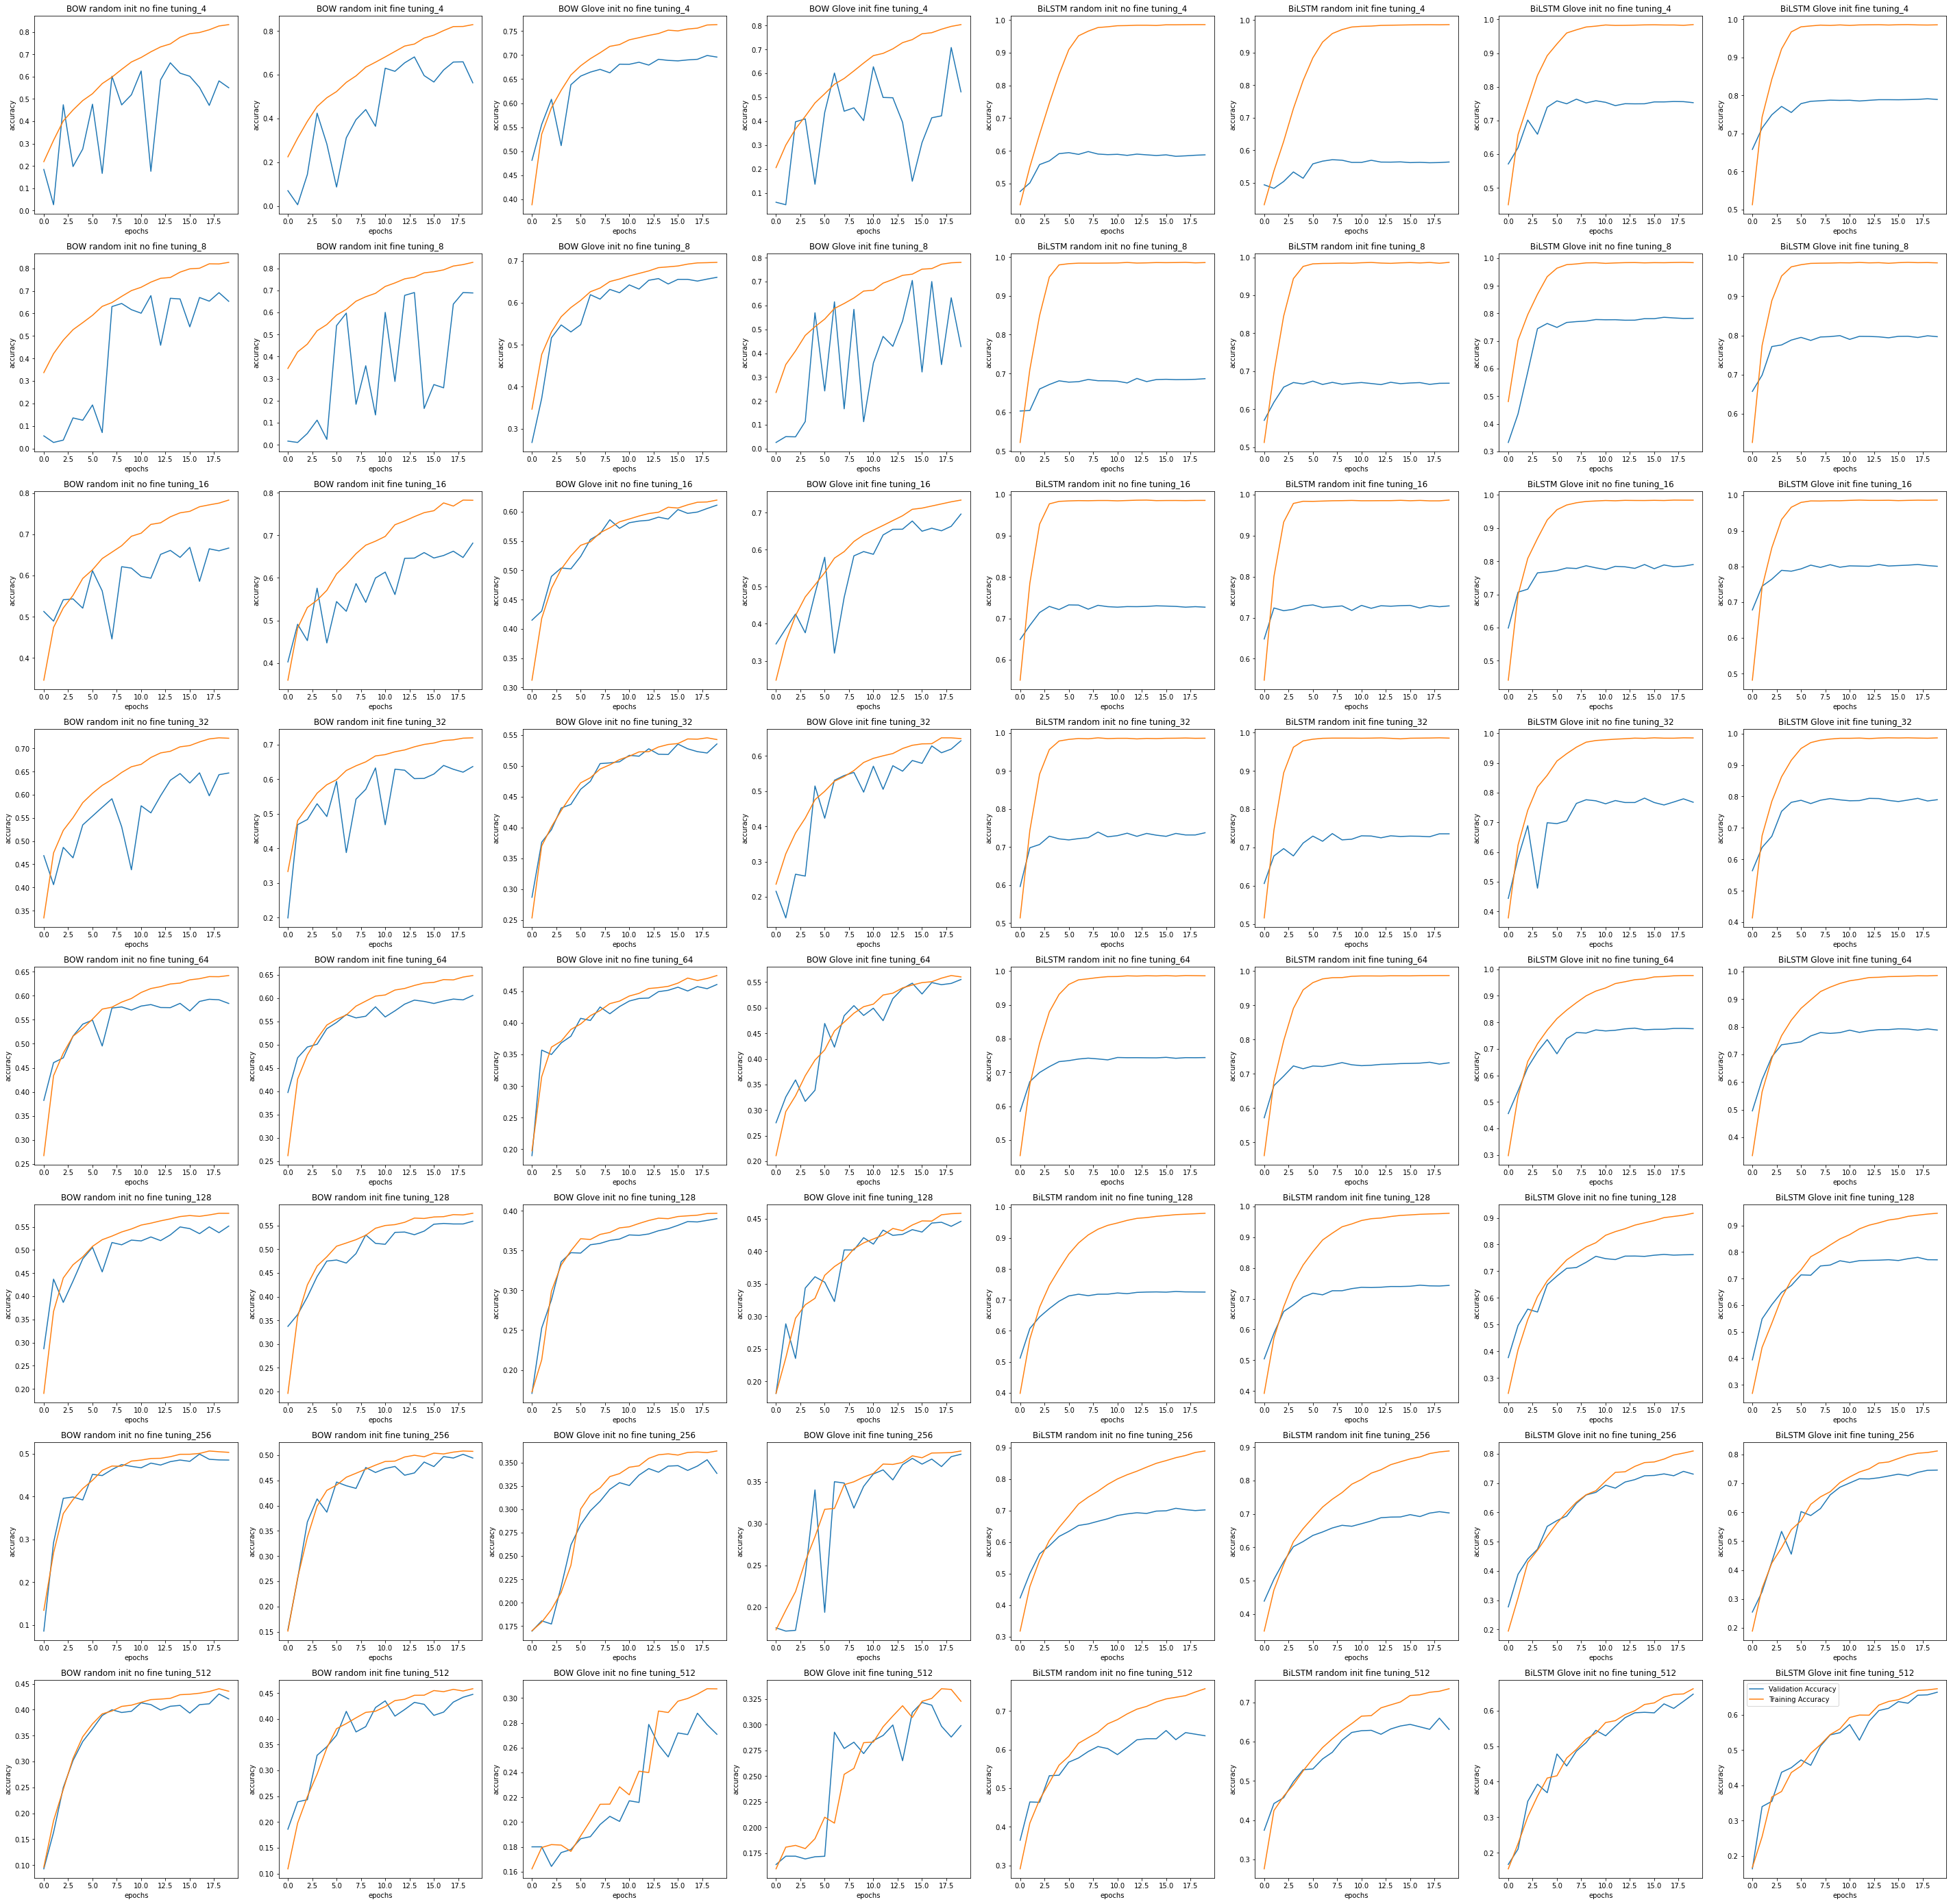

In [14]:
import matplotlib.pyplot as plt
n=len(model_list)//len(BATCH_SIZES)
fig, axs = plt.subplots(len(BATCH_SIZES), 8,figsize=(50,50))

for i,(name, m) in enumerate(zip(model_names,model_list)):
  axs[i//n,i%8].set_title(name)
  axs[i//n,i%8].plot(range(len(m.valid_accuracy)),m.valid_accuracy,label="Validation Accuracy")
  axs[i//n,i%8].plot(range(len(m.train_accuracy)),m.train_accuracy,label="Training Accuracy")
  axs[i//n,i%8].set(xlabel='epochs', ylabel='accuracy')
plt.legend()
plt.show()

We can see a good trade-off accuracy and stability at 32 and 64 batch sizes, that is we are able to achieve more than 50% accuracy in less than 10 epochs with less fluctuations. So we will make use of 64 only

## Identifying the best LR for batch size 64

In [15]:
import pandas as pd

In [16]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = .3
split = int(np.floor(validation_split * dataset_size))
np.random.seed(SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
batch_size = 64
train_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
valid_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=validation_sampler)

#Split data for validation
models=dict()
model_names = []
accuracy_dict = dict()
for lr in np.arange(0.1,3.1,0.1):
  models[lr]={"BOW random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BOW random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BOW Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BOW Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=False,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=lr,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=lr,gamma=0.9,device=device).to(device)}
  #Create batche generator
  accuracy_dict[lr]=dict()
  for name, model in models[lr].items():
    #Architecture of the model
    print(name)
    print(model)
    print("--------For LR: ",lr,"------------")
    #Train the model
    max_acc = model.fit(train_gen, valid_gen, N_EPOCHS, str(batch_size)+"-"+name)
    accuracy_dict[lr][name]=max_acc
    model_names.append(name+"_"+str(lr))
    print(f"Model with validation accuracy: {max_acc * 100:.1f}% was saved")

Streaming output truncated to the last 5000 lines.
Classifier(
  (embedding): Embedding(2091, 300, padding_idx=0)
  (lstm): LSTM(300, 50, bidirectional=True)
  (fc): Linear(in_features=100, out_features=50, bias=True)
  (criterion): CrossEntropyLoss()
)
--------For LR:  2.1 ------------
Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 2.6145(train)	|	Acc: 33.4%(train)
	Loss: 0.1962(valid)	|	Acc: 47.1%(valid)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 1.5320(train)	|	Acc: 60.0%(train)
	Loss: 0.0911(valid)	|	Acc: 66.7%(valid)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 1.0436(train)	|	Acc: 72.8%(train)
	Loss: 0.0893(valid)	|	Acc: 67.6%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.7209(train)	|	Acc: 80.7%(train)
	Loss: 0.0750(valid)	|	Acc: 72.4%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.5356(train)	|	Acc: 85.5%(train)
	Loss: 0.0875(valid)	|	Acc: 75.9%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.3718(train)	|	Acc: 90.6%(train)
	Loss: 0.1171(v

In [17]:
import pandas as pd
df = pd.DataFrame(accuracy_dict).T

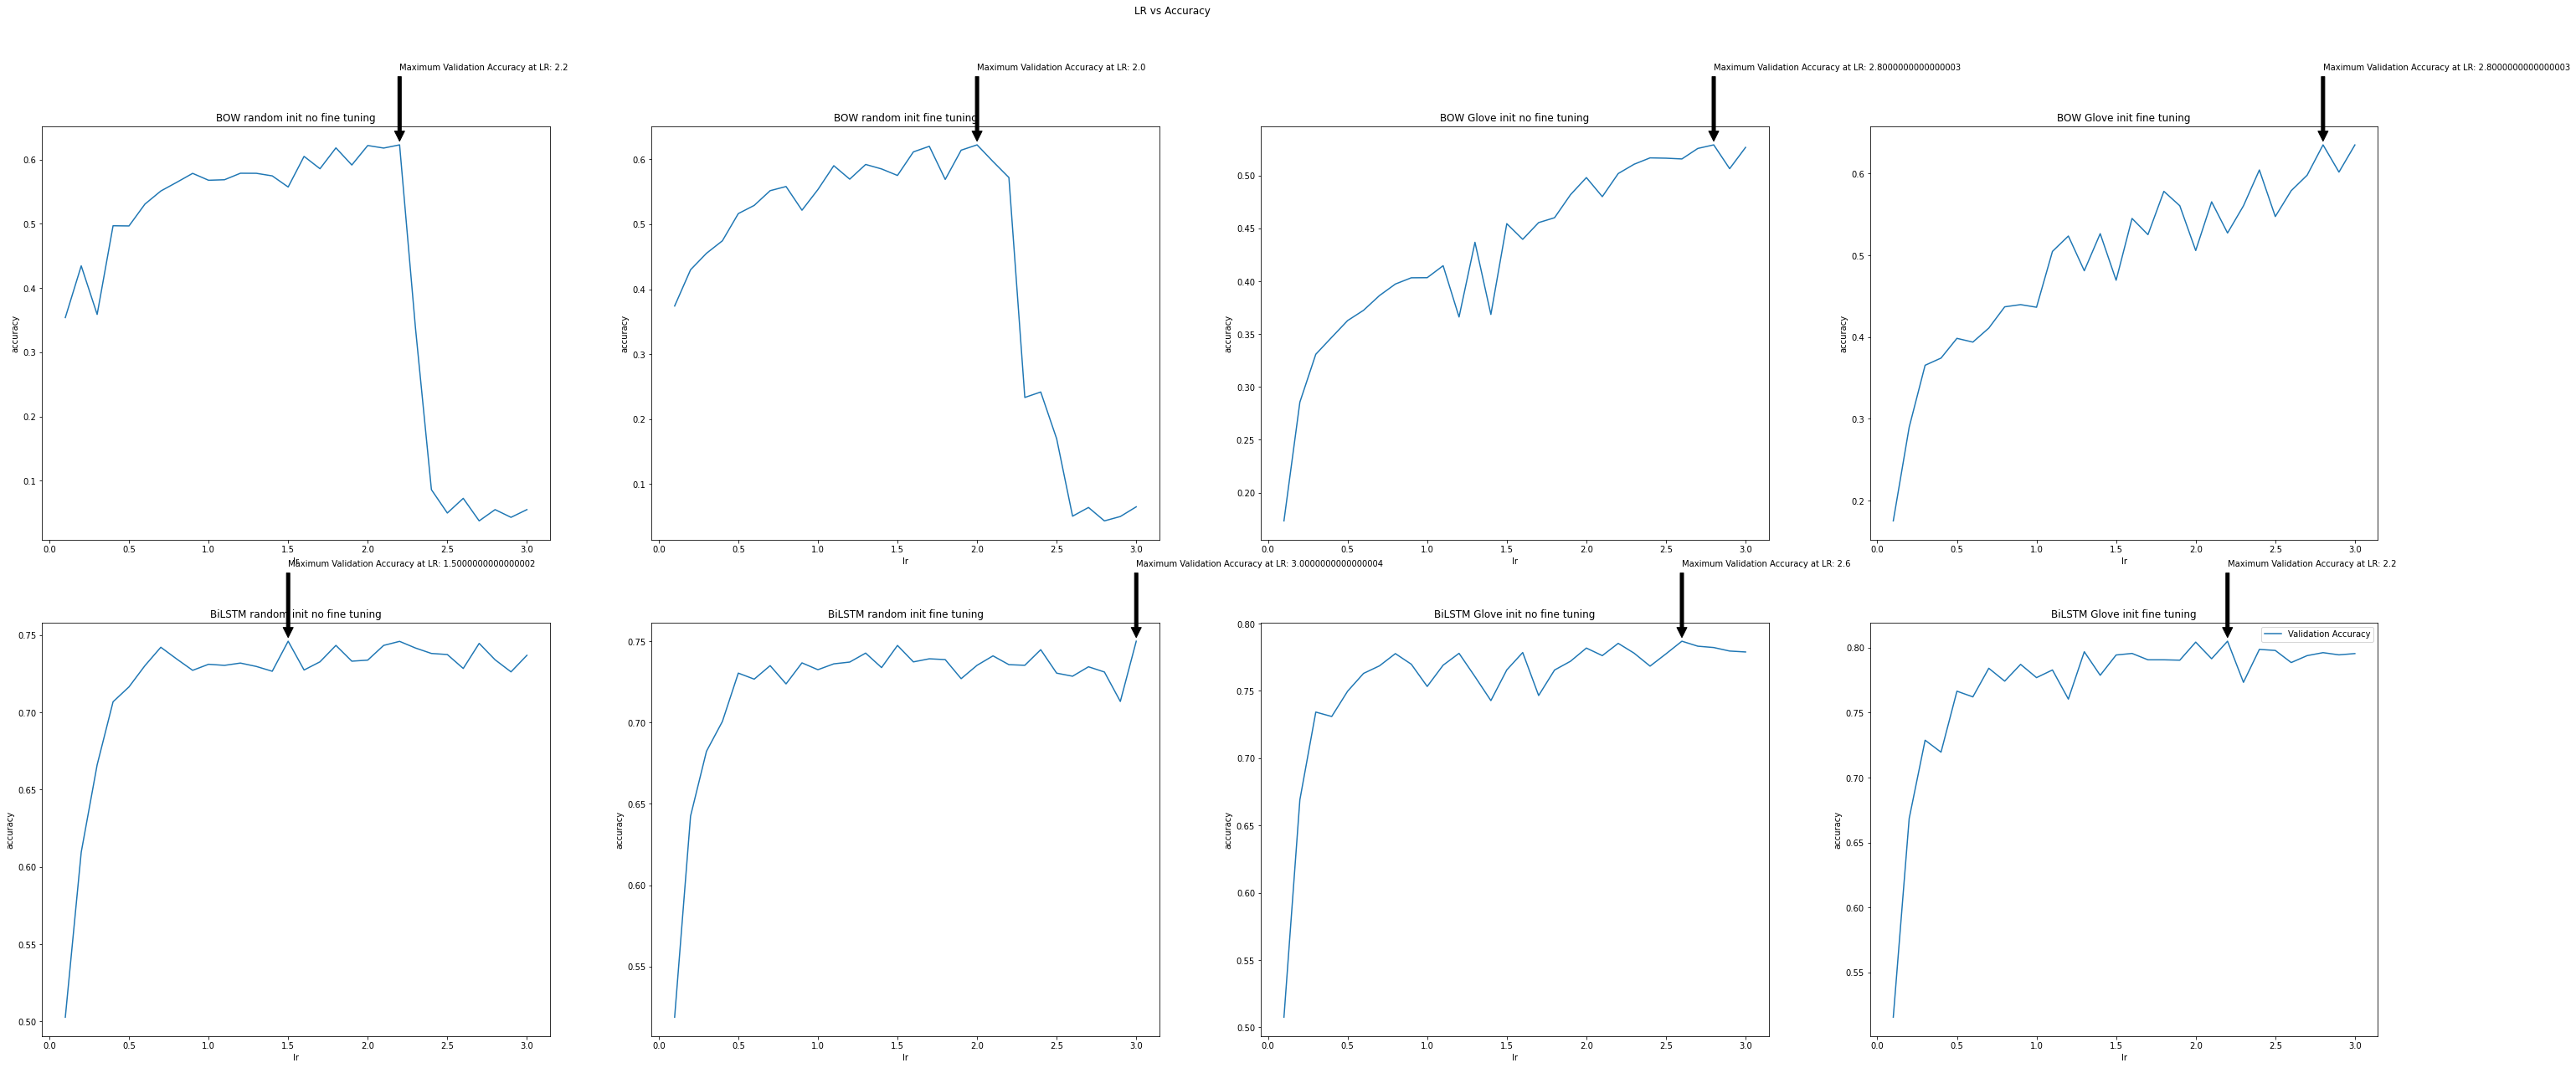

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 4,figsize=(50,20))
fig.suptitle("LR vs Accuracy")
for i, col in enumerate(df.columns):
  axs[i//4,i%4].set_title(col)
  axs[i//4,i%4].plot(df.index,df[col],label="Validation Accuracy")
  xmax, ymax = df[col].idxmax(),df[col].max()
  axs[i//4,i%4].annotate('Maximum Validation Accuracy at LR: '+str(xmax), xy=(xmax, ymax), xytext=(xmax, ymax+((df[col].max()-df[col].min())/5)),
            arrowprops=dict(facecolor='black', shrink=0.05),)
  axs[i//4,i%4].set(xlabel='lr', ylabel='accuracy')
plt.legend()
plt.show()

## Identifying the best train valid split for batch size 64 and learning 

In [23]:
import pandas as pd

In [24]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
#Split data for validation
models=dict()
model_names = []
accuracy_dict = dict()
batch_size = 64
for validation_split in np.arange(0.1,0.6,0.1):
  split = int(np.floor(validation_split * dataset_size))
  np.random.seed(SEED)
  np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]

  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  validation_sampler = SubsetRandomSampler(val_indices)
  train_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
  valid_gen = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=validation_sampler)
  models[validation_split]={"BOW random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=True,lr=2,gamma=0.9,device=device).to(device),
          "BOW random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=False,pre_emb=None,freeze=False,lr=1.4,gamma=0.9,device=device).to(device),
          "BOW Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=3,gamma=0.9,device=device).to(device),
          "BOW Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=False,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=2.9,gamma=0.9,device=device).to(device),
          "BiLSTM random init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=True,lr=2,gamma=0.9,device=device).to(device),
          "BiLSTM random init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=False,pre_emb=None,freeze=False,lr=2.7,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init no fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=True,lr=2.1,gamma=0.9,device=device).to(device),
          "BiLSTM Glove init fine tuning":Classifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, HIDDEN_NODES, use_bilstm=True,use_pre_emb=True,pre_emb=TEXT.itov,freeze=False,lr=2.3,gamma=0.9,device=device).to(device)}
  #Create batche generator
  accuracy_dict[validation_split]=dict()
  for name, model in models[validation_split].items():
    #Architecture of the model
    print(name)
    print(model)
    print("--------For LR: ",lr,"------------")
    #Train the model
    max_acc = model.fit(train_gen, valid_gen, N_EPOCHS, str(batch_size)+"-"+name)
    accuracy_dict[validation_split][name]=max_acc
    model_names.append(name+"_"+str(validation_split))
    print(f"Model with validation accuracy: {max_acc * 100:.1f}% was saved")

BOW random init no fine tuning
Classifier(
  (embedding): EmbeddingBag(2091, 200, mode=mean)
  (fc): Linear(in_features=200, out_features=50, bias=True)
  (criterion): CrossEntropyLoss()
)
--------For LR:  3.0000000000000004 ------------
Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 5.5935(train)	|	Acc: 28.1%(train)
	Loss: 0.5743(valid)	|	Acc: 49.2%(valid)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 2.2030(train)	|	Acc: 45.4%(train)
	Loss: 0.5119(valid)	|	Acc: 51.4%(valid)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 1.9837(train)	|	Acc: 50.6%(train)
	Loss: 0.3910(valid)	|	Acc: 52.2%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 1.8195(train)	|	Acc: 54.8%(train)
	Loss: 0.3696(valid)	|	Acc: 58.5%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 1.7144(train)	|	Acc: 57.0%(train)
	Loss: 0.3310(valid)	|	Acc: 48.6%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 1.6423(train)	|	Acc: 58.1%(train)
	Loss: 0.3433(valid)	|	Acc: 57.2%(valid)
Epoch: 7  | time in 0 mi

In [25]:
import pandas as pd
df = pd.DataFrame(accuracy_dict).T

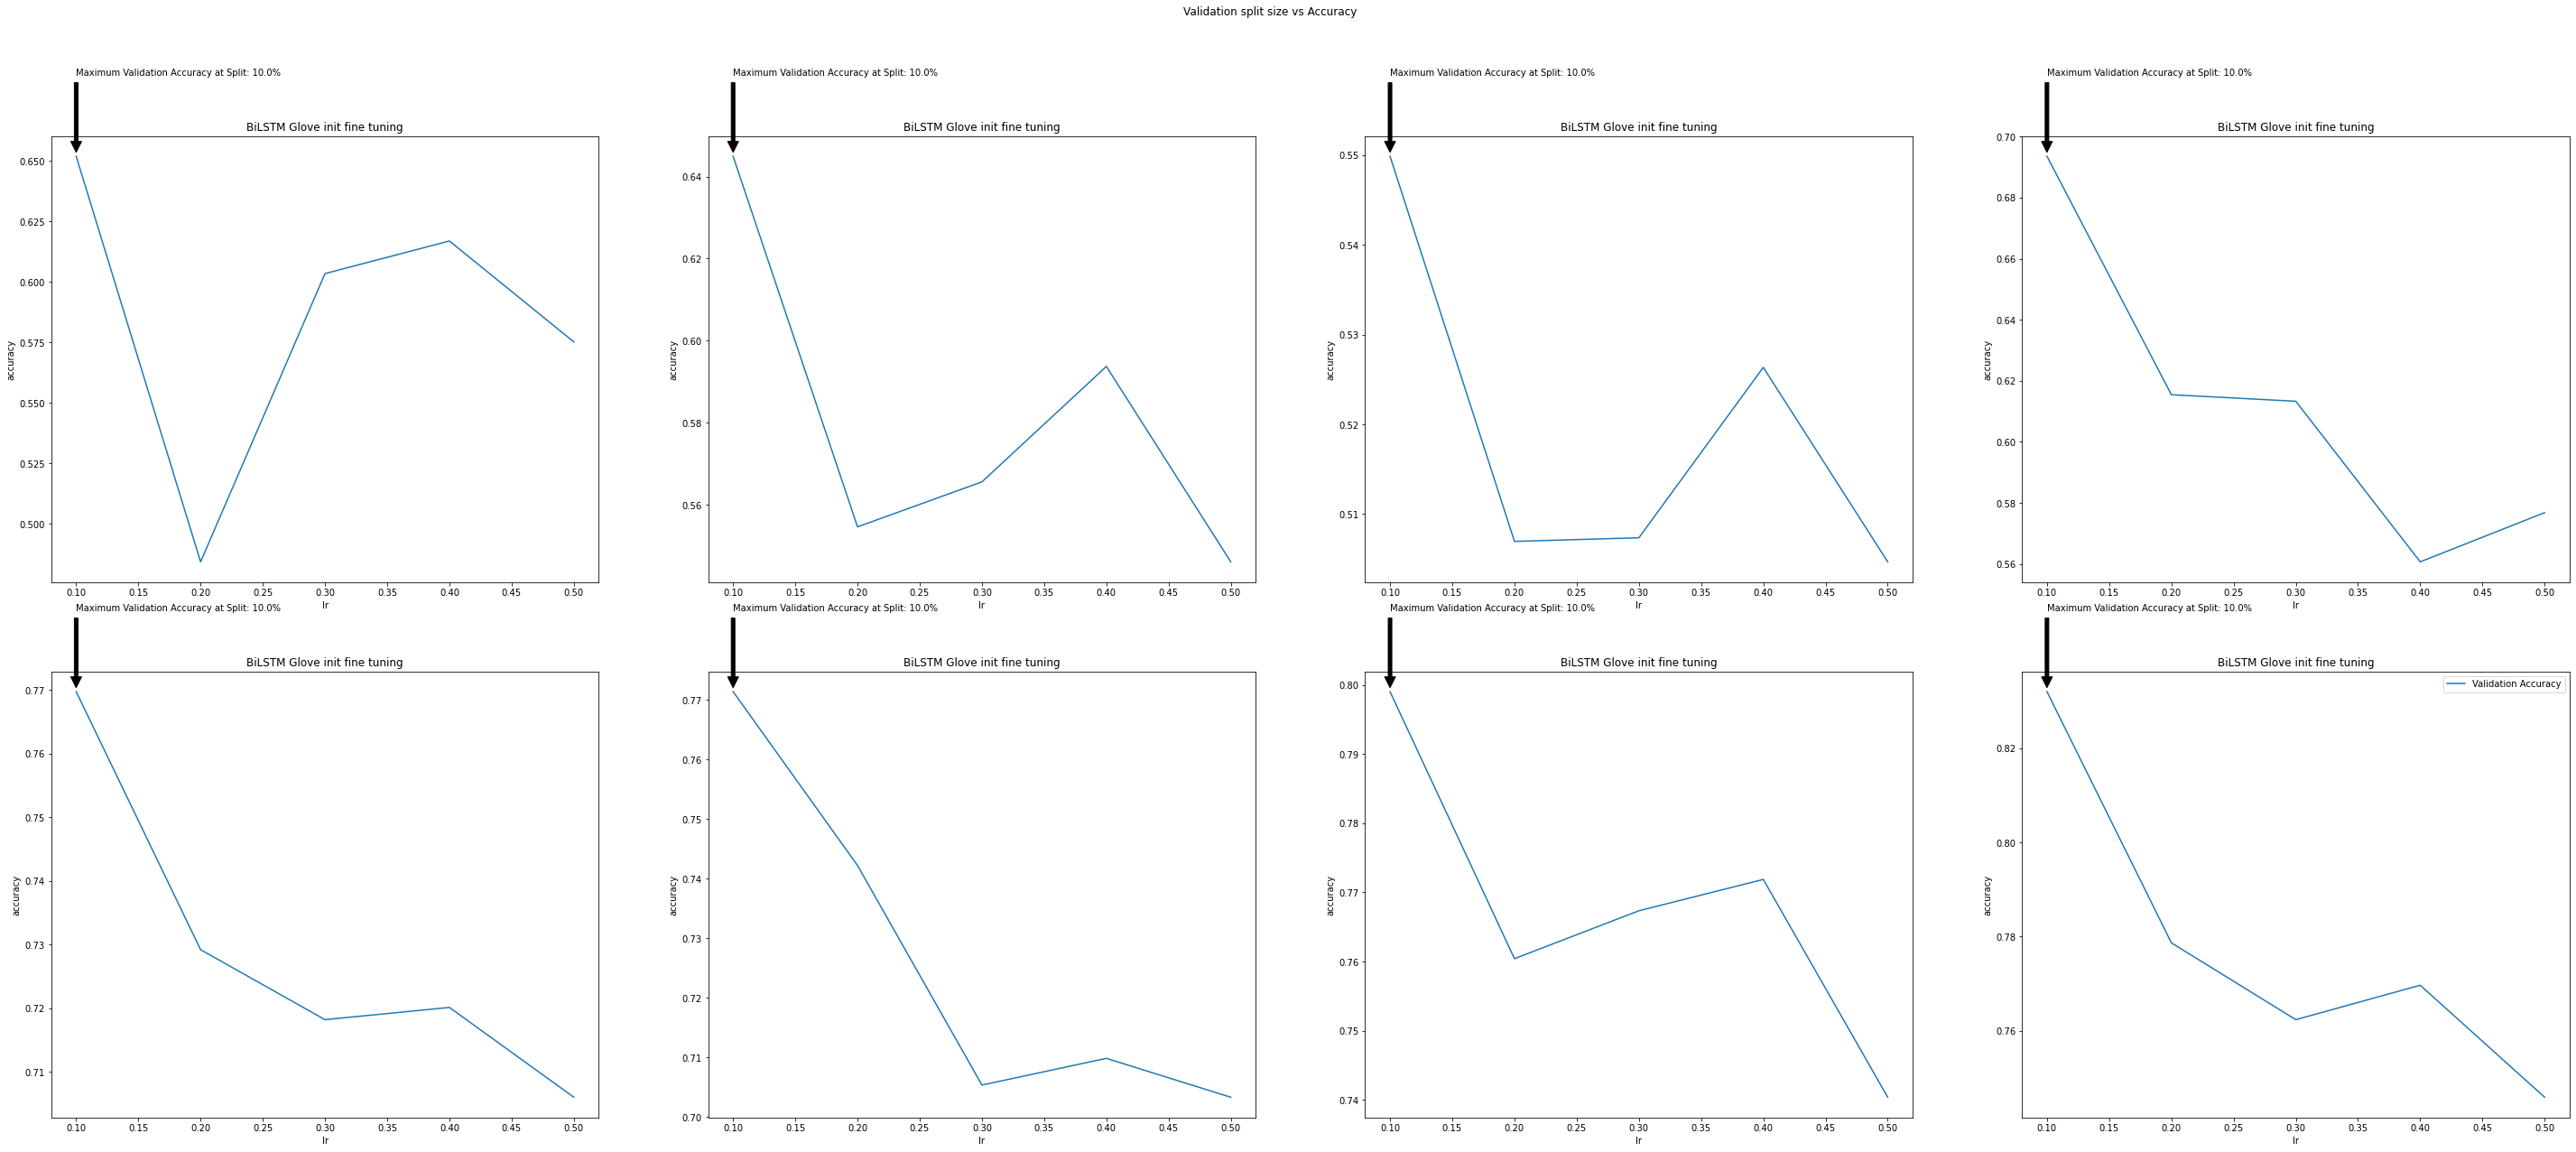

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 4,figsize=(50,20))
fig.suptitle("Validation split size vs Accuracy")
for i, col in enumerate(df.columns):
  axs[i//4,i%4].set_title(name)

  axs[i//4,i%4].plot(df.index,df[col],label="Validation Accuracy")
  xmax, ymax = df[col].idxmax(),df[col].max()
  axs[i//4,i%4].annotate('Maximum Validation Accuracy at Split: '+str(xmax*100)+"%", xy=(xmax, ymax), xytext=(xmax, ymax+((df[col].max()-df[col].min())/5)),
            arrowprops=dict(facecolor='black', shrink=0.05),)
  axs[i//4,i%4].set(xlabel='lr', ylabel='accuracy')
plt.legend()
plt.show()

## Confusion Matrix

In [27]:
from sklearn.metrics import f1_score

In [28]:
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve
print('Checking the results of test dataset...')
final_models = []
for a,b in zip(df.columns,df.idxmax()):
  final_models.append((a,models[b][a]))
x_test = []
y_test_l = []
resp = requests.get('https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label')
test_text = resp.content.decode(errors="ignore").splitlines()
for line in test_text:
  label, text = line.split(' ',1)
  x_test.append(text)
  y_test_l.append(label)
x_test = TEXT.convert_sentences_to_encoding(x_test)
y_test = np.array(LABEL.convert_labels_to_encodings(y_test_l))

conf_mat=dict()
for name, m in final_models:
  y_pred = m.predict(x_test)
  test_acc = (y_pred == y_test).sum().item()/len(y_test)
  title = f"Name: {name} - Accuracy: {test_acc * 100:.1f}%(test) - F1-score: {f1_score(y_test,y_pred,average='weighted')}"
  print(title)
  conf_mat[title] = confusion_matrix(LABEL.convert_encodings_to_labels(y_pred),y_test_l,labels=np.unique(y_test_l))
  
model = Ensemble([x[1] for x in final_models],device)
y_pred = model.predict(x_test)
test_acc = (y_pred == y_test).sum().item()/len(y_test)
title = f"Ensemble model - Acc: {test_acc * 100:.1f}%(test)- F1-score: {f1_score(y_test,y_pred,average='weighted')}"
conf_mat[title] = confusion_matrix(LABEL.convert_encodings_to_labels(y_pred),y_test_l,labels=np.unique(y_test_l))
print(title)

Checking the results of test dataset...
Name: BOW random init no fine tuning - Accuracy: 32.8%(test) - F1-score: 0.36259157114776724
Name: BOW random init fine tuning - Accuracy: 23.2%(test) - F1-score: 0.28137219532126845
Name: BOW Glove init no fine tuning - Accuracy: 54.8%(test) - F1-score: 0.5405685715494288
Name: BOW Glove init fine tuning - Accuracy: 48.8%(test) - F1-score: 0.5000677126552401
Name: BiLSTM random init no fine tuning - Accuracy: 41.8%(test) - F1-score: 0.40328148353329146
Name: BiLSTM random init fine tuning - Accuracy: 38.4%(test) - F1-score: 0.39372351294406943
Name: BiLSTM Glove init no fine tuning - Accuracy: 59.4%(test) - F1-score: 0.6203776973169534
Name: BiLSTM Glove init fine tuning - Accuracy: 68.0%(test) - F1-score: 0.6755161451615534


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:665: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


Ensemble model - Acc: 66.4%(test)- F1-score: 0.6666796976522552


No handles with labels found to put in legend.


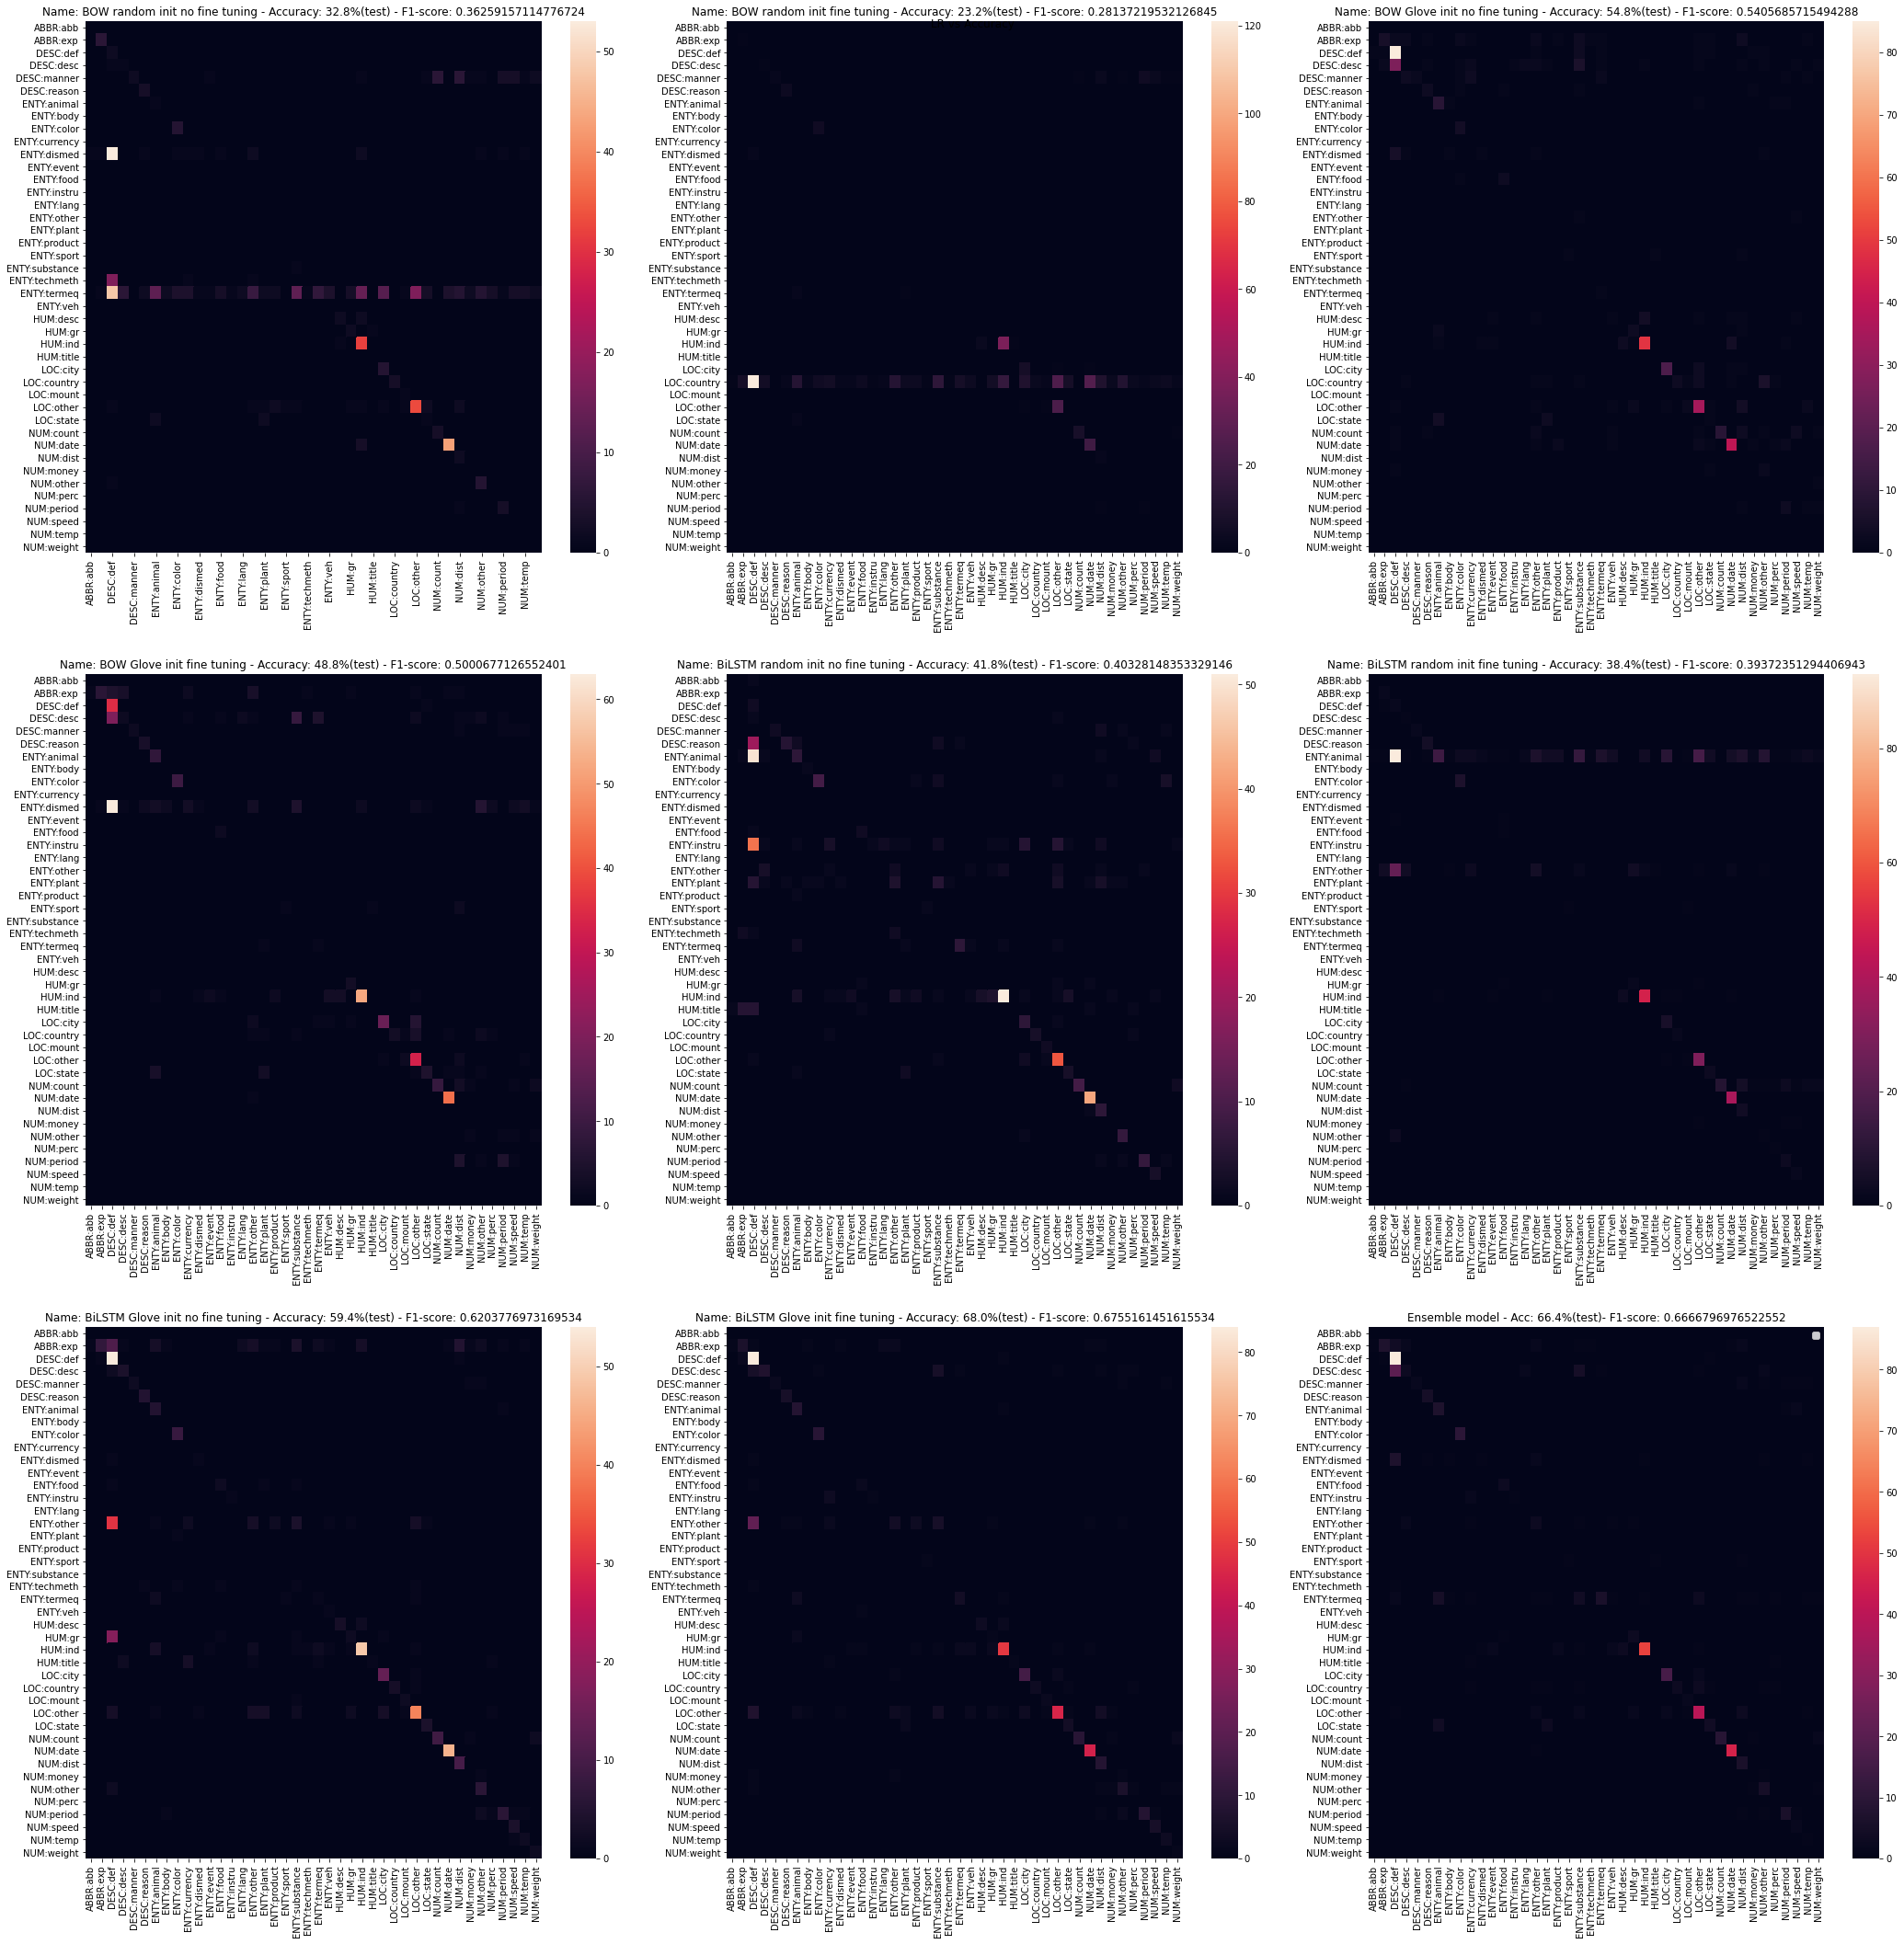

In [29]:
import seaborn as sn
fig, axs = plt.subplots(3, 3,figsize=(30,30))
fig.suptitle("Confusion matrices")
fig.suptitle("LR vs Accuracy")
fig.set_tight_layout(tight={"pad":3})
for i, (name,mat) in enumerate(conf_mat.items()):
  axs[i//3,i%3].set_title(name)
  df_cm = pd.DataFrame(mat,index=np.unique(y_test_l),columns=np.unique(y_test_l))
  sn.heatmap(df_cm,ax=axs[i//3,i%3])
plt.legend()
plt.show()